<a href="https://colab.research.google.com/github/joelma78/colab-github-actions/blob/main/ML2_Cacau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
caminho_zip = "/content/drive/MyDrive/ML2_Cacau/Image Datasets of Cocoa Beans for Taxonomy Nuances Evaluation.zip"
destino = "/content/drive/MyDrive/ML2_Cacau/data"

os.makedirs(destino, exist_ok=True)

with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
    arquivos = zip_ref.namelist()
    print(f"Total de arquivos no ZIP: {len(arquivos)}")

    for arquivo in arquivos:
        if arquivo.lower().endswith(('.jpg', '.png')):
            zip_ref.extract(arquivo, destino)



Total de arquivos no ZIP: 8


In [28]:
base_dir = "/content/drive/MyDrive/ML2_Cacau/data/version3_method_b/Enquadrado e Centralizado - Versão 3 - Método B"


In [29]:
classes = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])

print("Classes encontradas:")
for c in classes:
    print("-", c)


Classes encontradas:
- Agglutinated
- Brittle
- Compartmentalized_Brown
- Compartmentalized_PartiallyPurple
- Compartmentalized_Purple
- Compartmentalized_Slaty
- Compartmentalized_White
- Flattened
- Moldered
- Plated_Brown
- Plated_PartiallyPurple
- Plated_Purple
- Plated_Slaty
- Plated_White


Agglutinated: 100 imagens
Brittle: 100 imagens
Compartmentalized_Brown: 100 imagens
Compartmentalized_PartiallyPurple: 100 imagens
Compartmentalized_Purple: 100 imagens
Compartmentalized_Slaty: 100 imagens
Compartmentalized_White: 100 imagens
Flattened: 100 imagens
Moldered: 100 imagens
Plated_Brown: 100 imagens
Plated_PartiallyPurple: 100 imagens
Plated_Purple: 100 imagens
Plated_Slaty: 100 imagens
Plated_White: 100 imagens


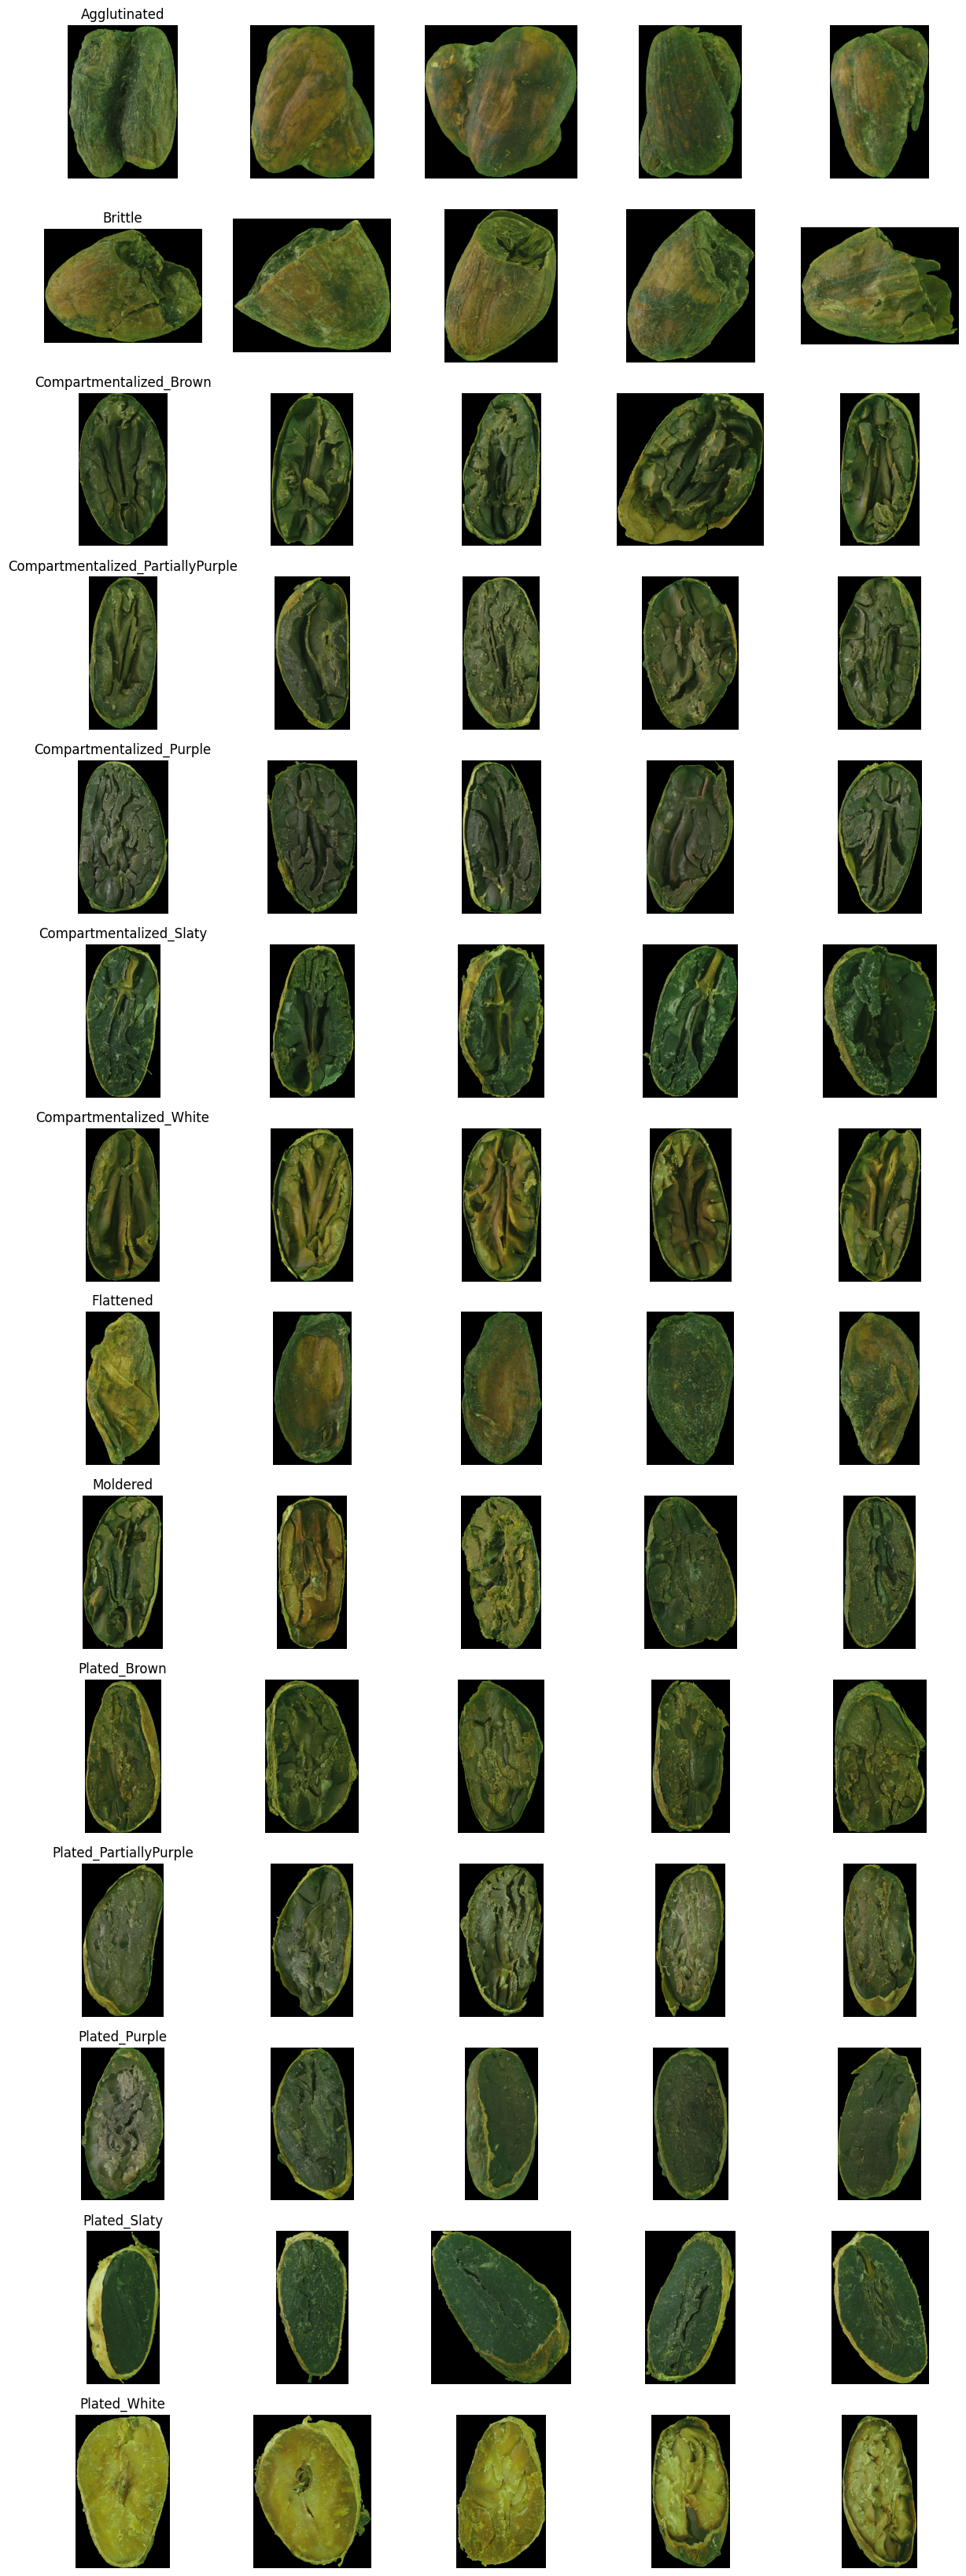

In [30]:
#EDA
import matplotlib.pyplot as plt
from PIL import Image

# Contagem de imagens por classe
for c in classes:
    class_dir = os.path.join(base_dir, c)
    num_imgs = len(os.listdir(class_dir))
    print(f"{c}: {num_imgs} imagens")

# Visualização de algumas imagens
fig, axes = plt.subplots(len(classes), 5, figsize=(15, 3*len(classes)))
for i, c in enumerate(classes):
    class_dir = os.path.join(base_dir, c)
    imgs = os.listdir(class_dir)[:5]  # pegar 5 imagens da classe
    for j, img_name in enumerate(imgs):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(c)
plt.show()


**Preparação de dados**

Objetivo: padronizar imagens para entrada da CNN.

Passos:

Redimensionar imagens para o tamanho esperado da CNN (224x224 para VGG/EfficientNet, 299x299 para Inception).

Normalizar valores de pixels (0-1 ou preprocess do Keras).

Criar partição holdout (treino/teste) reproduzível.

In [31]:
#Preparação de dados
from sklearn.model_selection import train_test_split
import numpy as np

# Arrays para features ainda não extraídas (placeholder)
X_paths = []
y_labels = []

for idx, c in enumerate(classes):
    class_dir = os.path.join(base_dir, c)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        X_paths.append(img_path)
        y_labels.append(idx)

X_paths = np.array(X_paths)
y_labels = np.array(y_labels)

# Partição holdout (usada por todos os experimentos)
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    X_paths, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)


**Extração de Características Visuais**

Usar CNNs sem as camadas finais de classificação (include_top=False).

Pesos fixos (weights='imagenet').

Salvar vetores de features em disco para não recalcular.

In [34]:
# Importações
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_incep
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff

# Função genérica para extrair features com barra de progresso
def extract_features(model, preprocess_fn, img_paths, target_size=(224, 224)):
    """
    Extrai features de uma lista de imagens usando um modelo pré-treinado.

    Args:
        model: CNN pré-treinada do Keras (sem a camada final de classificação)
        preprocess_fn: função de preprocessamento específica do modelo
        img_paths: lista de caminhos das imagens
        target_size: tupla (altura, largura) para redimensionamento da imagem

    Returns:
        np.array com shape (num_imagens, num_features)
    """
    features_list = []
    for path in tqdm(img_paths, desc=f"Extraindo features ({model.name})"):
        # Carregar e redimensionar imagem
        img = image.load_img(path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_fn(img_array)

        # Extrair features sem gerar output poluído
        features = model.predict(img_array, verbose=0)
        features_list.append(features.flatten())

    return np.array(features_list)


In [35]:
# Inicializando os modelos pré-treinados (sem camada final)
vgg_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
efficient_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

# Extração de features
X_train_vgg = extract_features(vgg_model, preprocess_vgg, X_train_paths, target_size=(224,224))
X_test_vgg  = extract_features(vgg_model, preprocess_vgg, X_test_paths, target_size=(224,224))

X_train_incep = extract_features(inception_model, preprocess_incep, X_train_paths, target_size=(299,299))
X_test_incep  = extract_features(inception_model, preprocess_incep, X_test_paths, target_size=(299,299))

X_train_eff = extract_features(efficient_model, preprocess_eff, X_train_paths, target_size=(224,224))
X_test_eff  = extract_features(efficient_model, preprocess_eff, X_test_paths, target_size=(224,224))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Extraindo features (efficientnetb0): 100%|██████████| 280/280 [00:57<00:00,  4.83it/s]


**Elaboração da Busca em Grade (GridSearch)**

Pipeline + GridSearch para VGG16

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline com StandardScaler, PCA e SVM
pipeline_vgg = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),  # ajustar se quiser testar mais componentes
    ('svm', SVC(kernel='rbf'))
])

# Grade de parâmetros para o GridSearch
param_grid_vgg = {
    'svm__C': [1, 10, 50, 100, 200],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

# GridSearch com validação cruzada 5-fold
grid_vgg = GridSearchCV(
    estimator=pipeline_vgg,
    param_grid=param_grid_vgg,
    cv=5,
    n_jobs=-1,
    verbose=2
)



In [60]:
# Treinar o GridSearch com as features do VGG16
grid_vgg.fit(X_train_vgg, y_train)

# Ver os melhores parâmetros e a melhor acurácia CV
print("Melhores parâmetros VGG16 + SVM:", grid_vgg.best_params_)
print("Melhor acurácia CV:", grid_vgg.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros VGG16 + SVM: {'svm__C': 50, 'svm__gamma': 0.001}
Melhor acurácia CV: 0.6633928571428571


Pipeline + GridSearch para InceptionV3

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline com StandardScaler, PCA e SVM
pipeline_incep = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),  # ajustar se quiser testar mais componentes
    ('svm', SVC(kernel='rbf'))
])

# Grade de parâmetros para o GridSearch
param_grid_incep = {
    'svm__C': [1, 10, 50, 100, 200],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

# GridSearch com validação cruzada 5-fold
grid_incep = GridSearchCV(
    estimator=pipeline_incep,
    param_grid=param_grid_incep,
    cv=5,
    n_jobs=-1,
    verbose=2
)


In [52]:
#Treinar o GridSearch
grid_incep.fit(X_train_incep, y_train)
print("Melhores parâmetros InceptionV3 + SVM:", grid_incep.best_params_)
print("Melhor acurácia CV:", grid_incep.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros InceptionV3 + SVM: {'svm__C': 100, 'svm__gamma': 0.001}
Melhor acurácia CV: 0.6660714285714285


Pipeline + GridSearch para EfficientNet

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Pipeline com StandardScaler, PCA e SVM
pipeline_eff = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),  # ajustar se quiser testar mais componentes
    ('svm', SVC(kernel='rbf'))
])

# Grade de parâmetros para o GridSearch
param_grid_eff = {
    'svm__C': [1, 10, 50, 100, 200],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

# GridSearch com validação cruzada 5-fold
grid_eff = GridSearchCV(
    estimator=pipeline_eff,
    param_grid=param_grid_eff,
    cv=5,
    n_jobs=-1,
    verbose=2
)



In [62]:
# Treinar usando as features extraídas da EfficientNetB0
grid_eff.fit(X_train_eff, y_train)

# Ver melhores parâmetros e melhor acurácia CV
print("Melhores parâmetros EfficientNetB0 + SVM:", grid_eff.best_params_)
print("Melhor acurácia CV:", grid_eff.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros EfficientNetB0 + SVM: {'svm__C': 1, 'svm__gamma': 0.001}
Melhor acurácia CV: 0.7267857142857144


In [67]:
grid_vgg.fit(X_train_vgg, y_train)
grid_incep.fit(X_train_incep, y_train)
grid_eff.fit(X_train_eff, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=100)),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 10, 50, 100, 200],
                         'svm__gamma': [0.001, 0.01, 0.1, 1]},
             verbose=2)

Comparar acurácia de validação cruzada dos 3 modelos

In [68]:
# Criar dicionário com os resultados de CV
cv_results = {
    'VGG16': grid_vgg.best_score_,
    'InceptionV3': grid_incep.best_score_,
    'EfficientNetB0': grid_eff.best_score_
}

# Mostrar resultados
for model_name, cv_score in cv_results.items():
    print(f"{model_name} - CV Acurácia: {round(cv_score*100,2)}%")

# Escolher o melhor modelo pelo CV
best_model_name = max(cv_results, key=cv_results.get)
print(f"\nMelhor modelo baseado em CV: {best_model_name}")

VGG16 - CV Acurácia: 66.52%
InceptionV3 - CV Acurácia: 66.16%
EfficientNetB0 - CV Acurácia: 72.41%

Melhor modelo baseado em CV: EfficientNetB0


Comparação, teste e salvamento dos 3 Modelos

In [69]:
# -----------------------------
#  Comparar acurácia CV dos 3 modelos
# -----------------------------
cv_results = {
    'VGG16': grid_vgg.best_score_,
    'InceptionV3': grid_incep.best_score_,
    'EfficientNetB0': grid_eff.best_score_
}

print("Acurácia CV de cada modelo:")
for model_name, cv_score in cv_results.items():
    print(f"{model_name}: {round(cv_score*100,2)}%")

# Selecionar o melhor modelo pelo CV
best_model_name = max(cv_results, key=cv_results.get)
print(f"\nMelhor modelo baseado em CV: {best_model_name}")



Acurácia CV de cada modelo:
VGG16: 66.52%
InceptionV3: 66.16%
EfficientNetB0: 72.41%

Melhor modelo baseado em CV: EfficientNetB0


In [70]:
# -----------------------------
#  Selecionar o pipeline do melhor modelo
# -----------------------------
if best_model_name == 'VGG16':
    best_model = grid_vgg
    X_test_best = X_test_vgg
elif best_model_name == 'InceptionV3':
    best_model = grid_incep
    X_test_best = X_test_incep
else:
    best_model = grid_eff
    X_test_best = X_test_eff


Acurácia final no teste (EfficientNetB0): 72.5%

Relatório completo:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.86      0.90      0.88        20
           2       0.67      0.80      0.73        20
           3       0.47      0.45      0.46        20
           4       0.76      0.80      0.78        20
           5       0.68      0.95      0.79        20
           6       0.79      0.75      0.77        20
           7       0.95      0.90      0.92        20
           8       0.67      0.50      0.57        20
           9       0.45      0.45      0.45        20
          10       0.47      0.45      0.46        20
          11       0.63      0.60      0.62        20
          12       0.95      0.90      0.92        20
          13       0.88      0.70      0.78        20

    accuracy                           0.72       280
   macro avg       0.73      0.72      0.72       280
weighted a

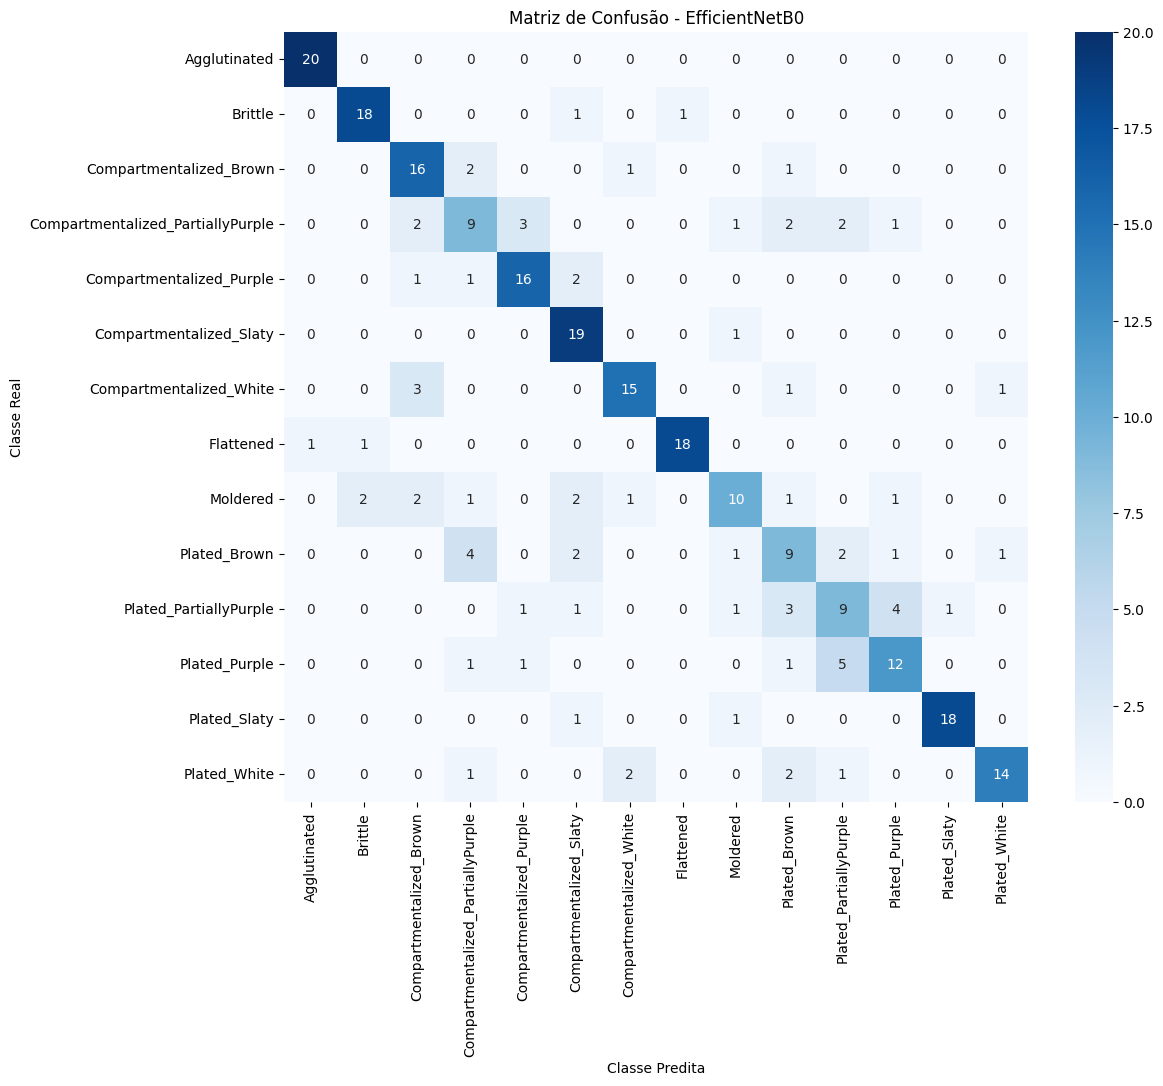

In [72]:
# -----------------------------
# Avaliar no conjunto de teste apenas o melhor modelo
# -----------------------------
# Importações necessárias
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Previsão no teste
y_pred_best = best_model.predict(X_test_best)

# 1️⃣ Acurácia
acc = round(accuracy_score(y_test, y_pred_best)*100, 2)
print(f"\nAcurácia final no teste ({best_model_name}): {acc}%\n")

# 2️⃣ Relatório completo
print("Relatório completo:")
print(classification_report(y_test, y_pred_best))

# 3️⃣ Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()



In [73]:

# -----------------------------
#  Salvar o modelo final
# -----------------------------
import joblib, os

os.makedirs("modelos_trained", exist_ok=True)
model_filename = f"modelos_trained/svm_best_model_{best_model_name}.pkl"
joblib.dump(best_model, model_filename)
print(f"\nModelo final ({best_model_name}) salvo com sucesso em: {model_filename}")



Modelo final (EfficientNetB0) salvo com sucesso em: modelos_trained/svm_best_model_EfficientNetB0.pkl


**Análise dos Resultados**

Criar tabela comparativa das três CNNs (VGG, Inception, EfficientNet)
Mostrar matrizes de confusão dos três melhores modelos.

Comentar qual CNN foi mais eficaz, por quê, e se superou o baseline de 89,79%.